# plot_precision_recall.ipynb

## Ref
- [RandomForestClassify](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [Receiver Operating Characteristic (ROC) with cross validation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py)
- [!!Precision-Recall](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)
- [!!StratifiedKFold (for cross validation)](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.StratifiedKFold.html)

## Code
1. configure: 配置分类器、选择的特征
2. load_data: X = features, y = labels， 得到训练数据
3. train_test_split(): 0.66切分训练集
4. train_model(X, y): 交叉验证，再把结果合在一起
5. precision_recall(y_preds, y_probs): 得到各trashhold的precision和recall
6. main部分：训练不同的模型(train_model)，得到不同的precision_recall, plt绘出曲线， 添加相应的标签

[0]
273 1
shape: (273,) (273, 2) (273,)
[0, 4, 5, 8]
273 4
shape: (273,) (273, 2) (273,)
[0, 4, 5, 7, 8, 9]
273 6
shape: (273,) (273, 2) (273,)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15]
273 13
shape: (273,) (273, 2) (273,)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
273 19
shape: (273,) (273, 2) (273,)


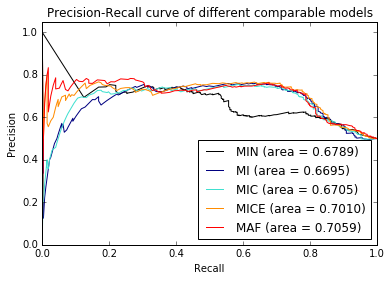

In [2]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

# configure

clf = RandomForestClassifier()

names = ['MIN', 'MI', 'MIC', 'MICE', 'MAF']
model = {
    "MIN": [1],
    "MI": [1, 5, 6, 9],
    "MIC": [1, 5, 6, 8, 9, 10],
    "MICE": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 16],
    "MICED": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17],
    "MAF": range(1, 20)
}
for key in model:
    model[key] = list(map(lambda x: x - 1, model[key]))


# import some data to play with
def load_data(feature_list):
    print(feature_list)

    file_name = 'final-data.csv'
    X = []
    y = []
    with open(file_name) as f:
        for line in f:
            line = line.strip().split(',')
            x = map(float, line[:-1])
            x = list(x)
            filter_x = []
            for idx in feature_list:
                filter_x.append(x[idx])
            X.append(filter_x)
            y.append(int(line[-1]))
            # print(X[-1], y[-1])
    X = np.array(X)
    y = np.array(y)
    return X, y


def train_test_split(model_name='MAF'):
    
    X, y = load_data(model[model_name])
    n_data, n_feat = X.shape
    print(n_data, n_feat)

    n_train = n_data * 2 / 3

    print('train [%d, %d)' % (0, n_train))
    print('test [%d, %d)' % (n_train, n_data))

    train_X = X[:n_train, ]
    train_y = y[:n_train]

    test_X = X[n_train:, ]
    test_y = y[n_train:]

    clf.fit(train_X, train_y)
    y_pred = list(clf.predict(test_X))

    output_file = 'output.txt'
    with open(output_file, 'w') as f:
        for idx, y_ in enumerate(y_pred):
            print("%d, %d, %d\n" % (n_train + idx, test_y[idx], y_pred[idx]), file=f)

def train_model(X, y, output_file=None):

    from sklearn.cross_validation import StratifiedKFold
    skf = StratifiedKFold(y, n_folds=10, random_state=1)

    n_data, n_feat = X.shape
    print(n_data, n_feat)

    probs = np.zeros((n_data, 2), dtype=np.float32)
    preds = np.zeros((n_data, ), dtype=np.int32)

    for train_index, test_index in skf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = RandomForestClassifier(n_estimators=300)
        clf.fit(X_train, y_train)
        probs_ = clf.predict_proba(X_test)
        preds_ = clf.predict(X_test)
        for idx, index in enumerate(test_index):
            preds[index] = preds_[idx]
            probs[index] = probs_[idx]

    if output_file is not None:
        # write to file
        with open(output_file, 'w') as f:
            for idx, y_ in enumerate(preds):
                print("%d, %d, %d" % (idx, y[idx], preds[idx]), file=f)

    return preds, probs

def precision_recall(y_test_, y_score, n_classes=2):

    # transform to binary label format
    y_test = np.zeros((len(y_test_), 2), dtype=np.int32)
    for idx, y_ in enumerate(y_test_):
        y_test[idx, y_] = 1

    # precision[0]: list
    # recall[0]: list
    # average_precision: score
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])

        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

    # Compute micro-average ROC curve and ROC area
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())

    average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")

    """Plot Precision-Recall curve
    plt.clf()
    plt.plot(recall["micro"], precision["micro"], lw=lw, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision["micro"]))
    plt.legend(loc="lower left")
    plt.show()
    """
    return recall, precision, average_precision



colors = ['black', 'navy', 'turquoise', 'darkorange', 'red']
lw = 1
plt.clf()

for idx, name in enumerate(names):
    X, y = load_data(model[name])
    y_preds, y_probs = train_model(X, y)

    print("shape:", y_preds.shape, y_probs.shape, y.shape)

    recall, precision, average_precision = precision_recall(y, y_probs)

    plt.plot(recall["micro"], precision["micro"], color=colors[idx], lw=lw,
             label='{0:s} (area = {1:0.4f})'.format(name, average_precision["micro"]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve of different comparable models')
plt.legend(loc="lower right")
plt.show()
